In [3]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import pickle

Get HSA names

In [4]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/2904833141.py:1: DtypeWarning: Columns (43,45,46,48,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')


Functions

In [5]:
# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Try and match to states 
census_data = pd.read_csv('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/unemployment-x.csv')

geoData = geoData.merge(census_data, left_on=['id'], right_on=['id'])

In [6]:
def convert_state_to_code(dataframe, column_name):
    # List of state names in alphabetical order, including Washington, D.C.
    state_names = [
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
        'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming', 'Washington D.C.'
    ]

    # Create a dictionary to map state names to numerical codes
    state_to_code = {state: f'{index + 1:02}' for index, state in enumerate(state_names)}

    # Create a new column "state_code" based on the mapping
    dataframe['state_code'] = dataframe[column_name].map(state_to_code)
    
    return dataframe

In [7]:

data_by_HSA = convert_state_to_code(data_by_HSA, 'state')

In [8]:
data_by_HSA[data_by_HSA['state'] == 'Alabama'].to_csv("Alabama.csv")

In [10]:
size_of_test_dataset = 1

# Load the objects from the files with their original names
accuracy_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/accuracy_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))
npv_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/npv_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))
ppv_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/ppv_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))
sensitivity_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/sensitivity_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))
specificity_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/specificity_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))
ROC_by_HSA_full = pickle.load(open(f'/Users/rem76/Documents/COVID_projections/Six_month_models/ROC_by_HSA_full_size_of_test_dataset_{size_of_test_dataset}', 'rb'))


In [11]:
geoData['HSA_ID'] = None
for i, name in enumerate(geoData['id']):
    state = geoData.loc[i, 'state']
    filtered_rows = data_by_HSA[data_by_HSA['fips'] == name ]

    #filtered_rows = data_by_HSA[data_by_HSA['health_service_area'].str.contains(name, case=False) ]
    #filtered_rows = filtered_rows[filtered_rows['state'] == state]
    if(len(filtered_rows) > 1):
        geoData.loc[i, 'HSA_ID'] = filtered_rows['HSA_ID'].reset_index(drop=True)[0]

Add in values of auROC etc

In [12]:
geoData['accuracy'] = None

for i, HSA in enumerate(data_by_HSA['HSA_ID']):
    auROC = ROC_by_HSA_full[HSA].values()
    geoData.loc[geoData['HSA_ID'] == HSA, 'auROC'] = next(iter(ROC_by_HSA_full[HSA].values()))
    geoData.loc[geoData['HSA_ID'] == HSA, 'accuracy'] = next(iter(accuracy_by_HSA_full[HSA].values()))

Mainland

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/3217479515.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData_mainland = geoData_mainland.explode()


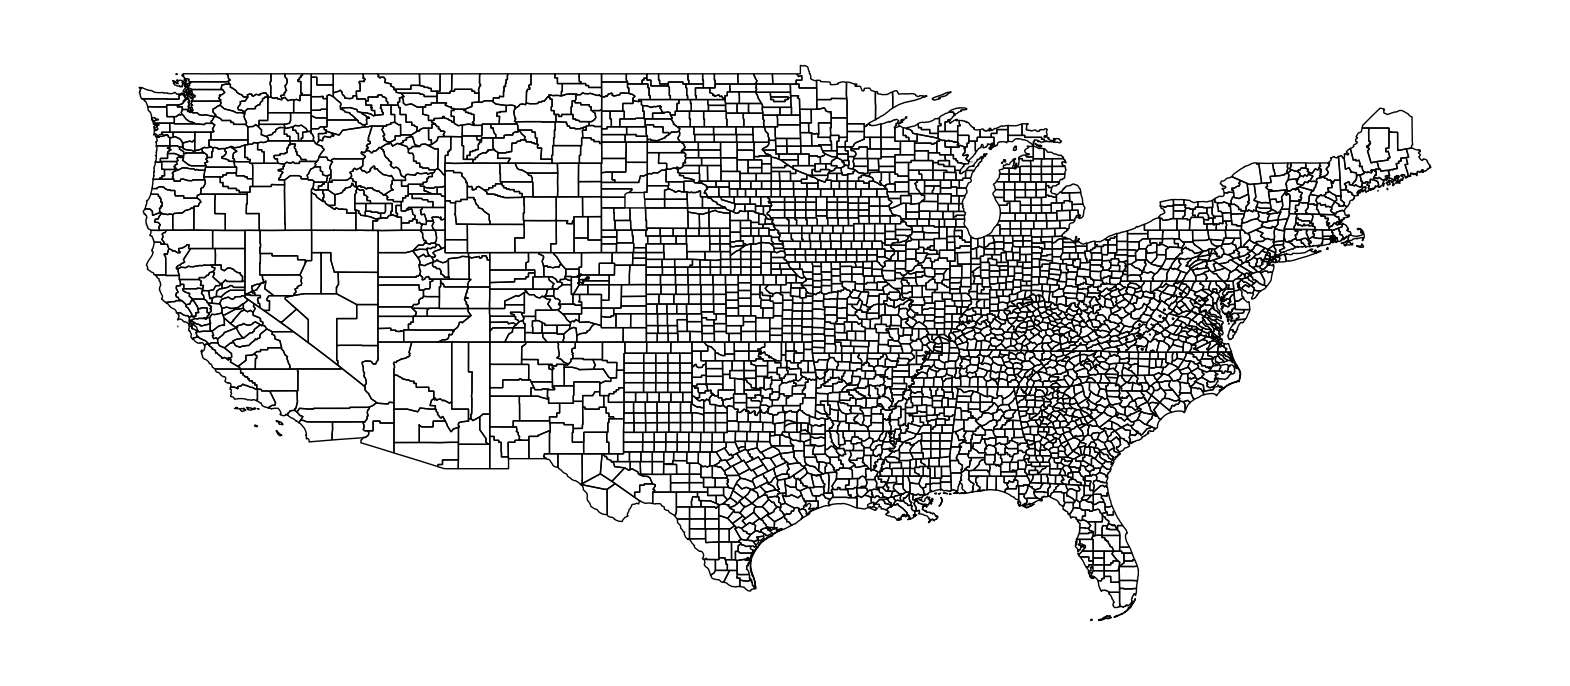

In [13]:



# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ['02', '15', '72']
geoData_mainland = geoData[~geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_mainland = geoData_mainland.explode()

# Basic plot with just county outlines
gplt.polyplot(geoData_mainland, figsize=(20, 20));

Hawai'i

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/2632184043.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData_HI = geoData_HI.explode()


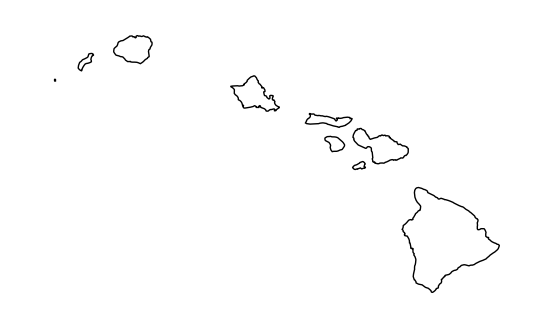

In [14]:
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ['15']
geoData_HI = geoData[geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_HI = geoData_HI.explode()

# Basic plot with just county outlines
gplt.polyplot(geoData_HI, figsize=(20, 4));

Alaska

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_49543/3075408503.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData_AK = geoData_AK.explode()


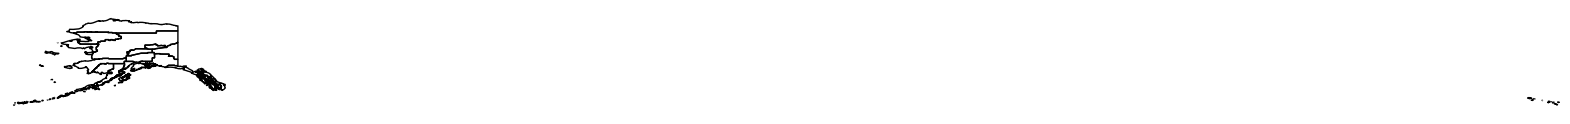

In [15]:

stateToRemove = ['02']
geoData_AK = geoData[geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_AK = geoData_AK.explode()

# Basic plot with just county outlines
gplt.polyplot(geoData_AK, figsize=(20, 4));

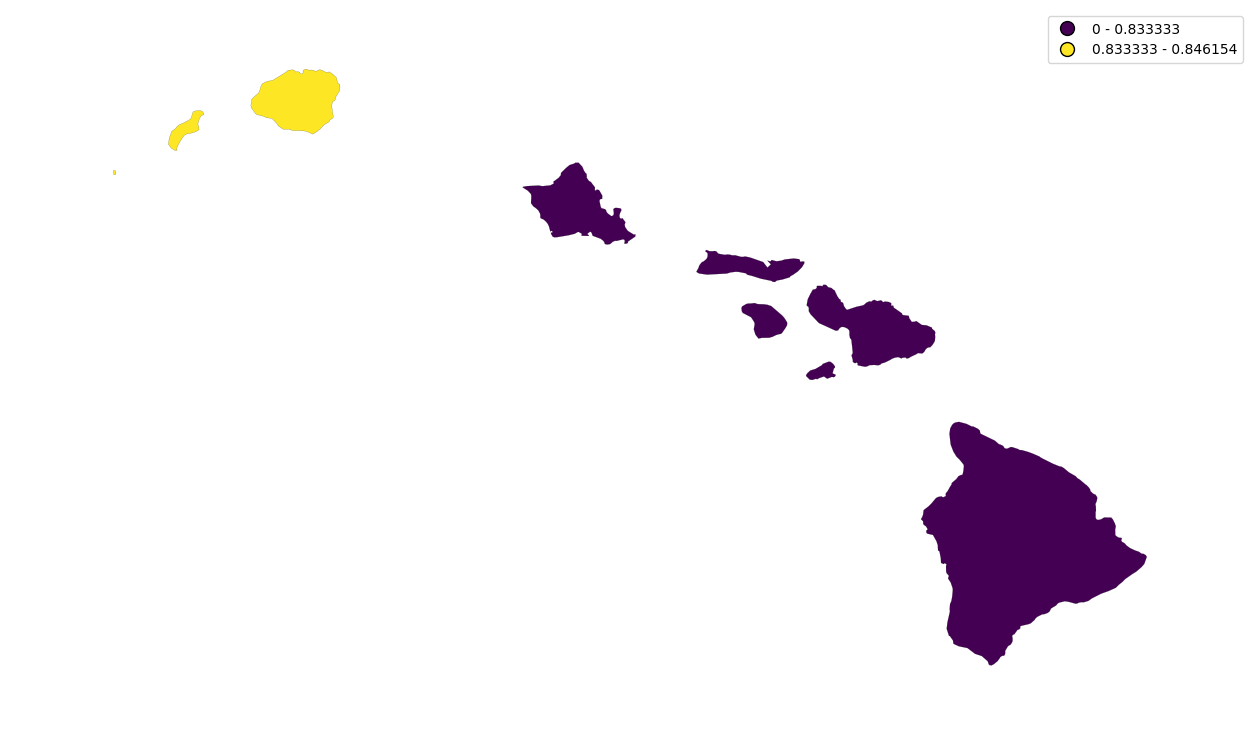

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_HI['accuracy'], k=2)

gplt.choropleth(geoData_HI, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);


In [17]:
geoData_mainland = geoData_mainland.dropna(subset=['accuracy'])


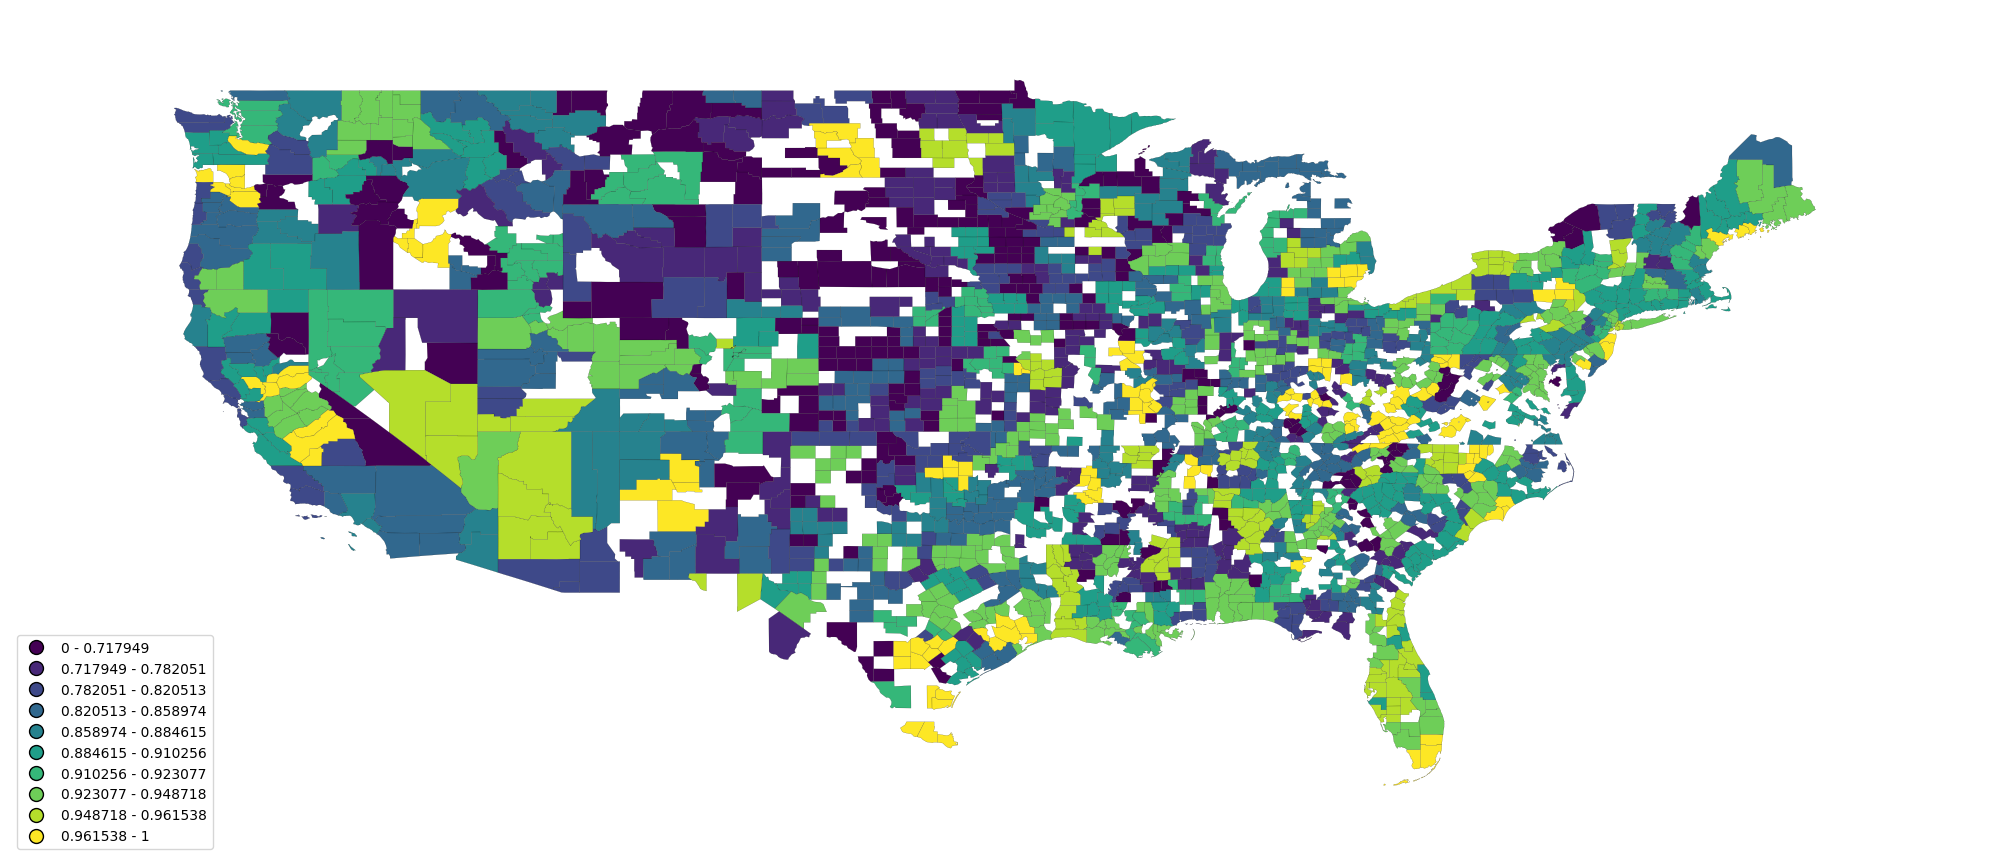

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_mainland['accuracy'], k=10)

gplt.choropleth(geoData_mainland, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);
plt.tight_layout()
plt.savefig('Graphs/USA_mainland_accuracy.png', dpi = 300)

/Users/rem76/miniconda3/envs/COVID_forecasting/lib/python3.11/site-packages/mapclassify/classifiers.py:257: UserWarning: Not enough unique values in array to form 2 classes. Setting k to 1.
  warnings.warn(


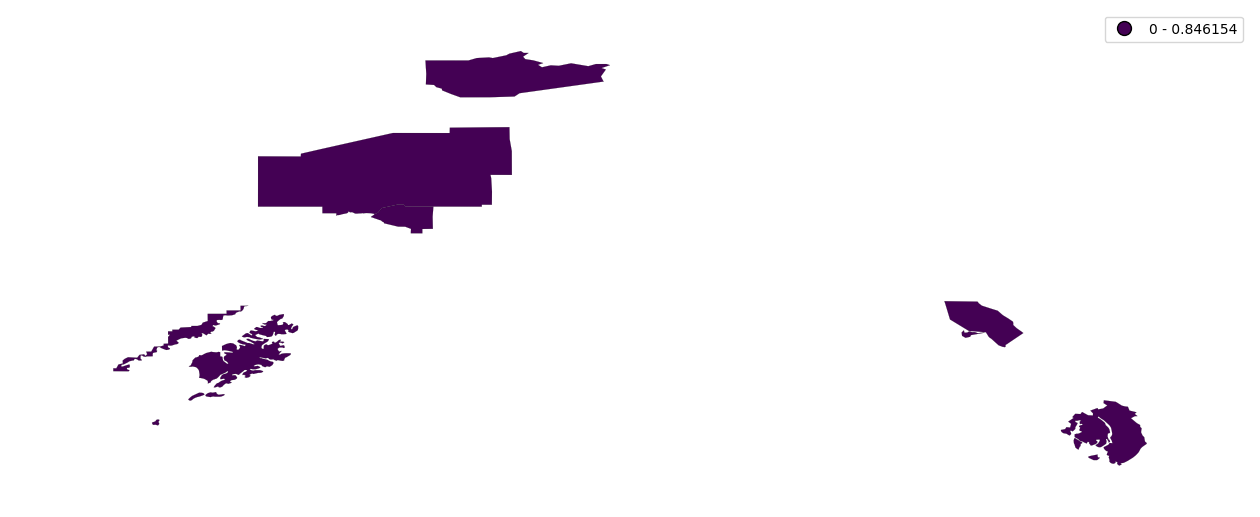

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
geoData_AK = geoData_AK.dropna(subset=['accuracy'])

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData_AK['accuracy'], k=2)

gplt.choropleth(geoData_AK, 
    hue="accuracy", 
    linewidth=.1,
    scheme=scheme, cmap='viridis',
    legend=True,
    edgecolor='black',
    ax=ax
);